Integrantes:

* Flores Esquivel Luis Antonio
* Hanna Gu
* Palacios Elizondo Kevin
* Sánchez Martinez Felipe
* Santiago Morales Andrea Karina



# Entrenamiento de una red neuronal

Al entrenar una red buscamos que ésta tenga un comportamiendo presumiblemente adecuado y observable en un conjunto de datos. Es decír a partir de los ejemplos esperamos que la red aprenda una función $f$ tal que la salida de la red imite el patrón en los datos. En nuestro caso, al utilizar el conjunto de entrenamiento MNIST esperamos que la función aprendida provea como salida el número al cual corresponde la imagen de entrada.

En este notebook implementaremos el descenso por gradiente usnado pytorch para entrenar la red que ya codificamos en el ejercicio anterior. Consideramos que que nuesto notebook es correcto si es que mejoramos el desempeño de la red previo a que sea entrenada.

Como ejemplo tenemos la figura siguiente, donde la entrada es una imagen en escala de grises y la salida es la clase '4' donde observamos que esa locación tiene la mayor probabilidad.

<img src="archivos/function_approx.png">

Imagen tomada de [1]

Instrucciones: completa el código donde aparece *TODO:* (Hacer en inglés)



Si ejecutas en COLAB debes copiar los archivos extra de este repositorio.

@juan1rving

## Retropropagación y Autograd

Pytorch provee el módulo *autograd* para calcular los gradientes, y si!, nos evita estar calculando las derivadas! Esto lo realiza a partir de mantener en la vista todas las operaciones que se ejecutan sobre los tensores.

Si deseas asegurarte que autograd siga a un tensor especificamos *requires_grad*. Esto se puede hacer en la creación o en cualquier momento. 

Veamos el siguiente código de ejemplo:

```python
# especificamos que la variable x es seguida por autograd
x = torch.zeros(1, requires_grad=True)
# si en algún momento desamos que temporalmente se deje de seguir el tensor usamos
>>> with torch.no_grad():
...     y = x * 2
# establecemos de nuevo el seguimiento
>>> y.requires_grad
```

Si queremos eliminar autograd de todos los tensores usamos `torch.set_grad_enabled(True|False)`.

Ahora bien, para calcular los gradientes simplemente usamos el método *backward()*. Por ejemplo para un tensor *cualquiera* hacemos *z.backward()*

Veamos a continuación el uso del gradiente.

In [1]:
# importamos paquetes
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import helper

In [2]:
# especificamos que el tensor x es seguido por autograd 
x = torch.randn(4, requires_grad=True)
print(x)

tensor([ 0.4276,  0.9983, -0.3502,  0.0591], requires_grad=True)


In [3]:
# generamos un nuevo tensor a partir de x
# por ejemplo elevemos al cuadrado la variable x
y = x**2
print(y)

tensor([0.1828, 0.9966, 0.1226, 0.0035], grad_fn=<PowBackward0>)


In [4]:
## con grad_fn observamos la operación que generó y, es decir una operación potencia (pow)
print(y.grad_fn)


In [5]:
# De esta forma es posible saber las operaciónes que generan cada tensor, y por tanto, es posible calcular el gradiente.
# Hagamos ahora una operación de media
z = y.mean()
print(z)

tensor(0.3264, grad_fn=<MeanBackward0>)


In [6]:
# hasta este momento los gradientes son cero
print(x.grad)

None


Para calcular los gradientes es necesario llamar al método *.backward* sobre la variable. Supongamos sobre *z*. Esto calcula el gradiente de z con respecto de x.

El gradiente analítico de las operaciónes que hicimos es:
$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

Ahora comprobemos

In [7]:
z.backward()
print(x.grad)

print(x/2)

tensor([ 0.2138,  0.4991, -0.1751,  0.0295])
tensor([ 0.2138,  0.4991, -0.1751,  0.0295], grad_fn=<DivBackward0>)


## Conjunto de datos y red neuronal

Ahora descargemos los datos y generemos una red tal cual lo vimos en el notebook anterior. 

In [8]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.Normalize([0.5],[0.5])
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [9]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('logits', nn.Linear(hidden_sizes[1], output_size))]))

# NOTA solo calcularemos los logits y definiremos la perdida a partir de ellos

## Entrenamiento de la red

Lo primero que definiremos será la función de pérdida (loss) que es nombrada en pytorch como **criterion**. En este ejemplo estamos utilizando softmax, asi que definimos el criterio como 
```
criterion = nn.CrossEntropyLoss()
```
Más tarde, en el entrenamiento, veremos que *loss = criterion(output, targets)* calcula la pérdida.

Lo segundo que definiremos será el optimizador, para este ejemplo usaremos SGD (stochastic gradient descent). Simplemente llamamos a *torch.optim.SGD* y le pasamos los parámetros de la red y el learning rate. La instrucción implementada se verá algo como lo siguiente: 
```
optimizer = optim.SGD(model.parameters(), lr=0.01)
```

In [10]:
# TODO: Define la pérdida 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

Antes de realizar el entrenamiento completo haremos un paso del aprendizaje. Este paso se compone de las siguientes tareas:

1. Realizar un pase frontal de la red
2. Utilizar los logits para calcular la pérdida
3. Realizar la retropropagación para calcular los gradientes.
4. Actualizar los pesos usando el optimizador.

Veamos el ejemplo


In [11]:
print('Initial weights - ', model.fc1.weight)


Initial weights -  Parameter containing:
tensor([[-0.0331,  0.0240, -0.0035,  ...,  0.0055, -0.0351,  0.0087],
        [-0.0224, -0.0248, -0.0231,  ..., -0.0043, -0.0271, -0.0085],
        [-0.0128,  0.0125, -0.0017,  ..., -0.0285,  0.0348,  0.0146],
        ...,
        [-0.0032, -0.0321,  0.0308,  ...,  0.0216, -0.0254, -0.0337],
        [ 0.0185, -0.0112, -0.0348,  ..., -0.0282, -0.0228, -0.0109],
        [-0.0352,  0.0239, -0.0018,  ...,  0.0120,  0.0128,  0.0177]],
       requires_grad=True)


In [12]:
images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Limpiar los gradientes por que se acumulan
optimizer.zero_grad()

# Pase hacia adelante
output = model.forward(images)
# Perdida
loss = criterion(output, labels)
# Pase de reversa
loss.backward()
print('Gradient -', model.fc1.weight.grad)
# Actualiza los pesos de acuerdo a un paso del optimizador
optimizer.step()

Gradient - tensor([[-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        [ 0.0015,  0.0015,  0.0015,  ...,  0.0015,  0.0015,  0.0015],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        ...,
        [ 0.0001,  0.0001,  0.0001,  ...,  0.0001,  0.0001,  0.0001],
        [ 0.0023,  0.0023,  0.0023,  ...,  0.0023,  0.0023,  0.0023],
        [ 0.0011,  0.0011,  0.0011,  ...,  0.0011,  0.0011,  0.0011]])


In [13]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[-0.0331,  0.0240, -0.0035,  ...,  0.0055, -0.0351,  0.0087],
        [-0.0224, -0.0248, -0.0231,  ..., -0.0043, -0.0272, -0.0086],
        [-0.0128,  0.0125, -0.0017,  ..., -0.0285,  0.0348,  0.0146],
        ...,
        [-0.0032, -0.0321,  0.0308,  ...,  0.0216, -0.0254, -0.0337],
        [ 0.0185, -0.0112, -0.0348,  ..., -0.0282, -0.0228, -0.0109],
        [-0.0352,  0.0239, -0.0019,  ...,  0.0120,  0.0128,  0.0177]],
       requires_grad=True)


## Entrenamiento por épocas

Ahora si, entrenemos la red por varias épocas. Para ello programaremos el algoritmo de  descenso por gradiente. De forma general éste funciona como sigue:

- Para un número de *épocas*:
    - Para cada *lote* en el conjunto de datos:
        - Salida = Red predice usando el *lote*
        - Calcular *pérdida* a partir de la *salida* y de las *etiquetas* reales
        - Términos de error = Retropropagación a partir de la *pérdida*
        - Actualizar pesos usando el optimizador
        
    

In [14]:
# hiperparámetros
# número de épocas
epochs = 5
tasa_de_aprendizaje = 0.003

# TODO: redefine la configuración del optimizador usando la tasa de aprendizaje objetivo
optimizer = optim.SGD(model.parameters(), lr = tasa_de_aprendizaje)

In [15]:
print_every = 40
steps = 0
losses = []
for e in range(epochs):
    running_loss = 0
    # en cada iteración del for cargamos un batch
    for images, labels in iter(trainloader):
        steps += 1
        # Aplanar las imagenes de MNIST
        images.resize_(images.size()[0], 784)
        
        # Reiniciar el gradiente
        optimizer.zero_grad()
        
        # TODO: Pase frontal de la red
        output = model.forward(images)
        
        # TODO: Estimar la perdida
        loss = criterion(output, labels)
        
        # TODO: Backprogation
        loss.backward()
        # print('Gradient -', model.fc1.weight.grad)
        
        # TODO: Actualizamos los pesos
        optimizer.step()
        
        
        # Guardamos la perdida para control del entrenamiento
        running_loss += loss.item()
        
        # imprimimos cada 40 lotes
        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            losses.append(running_loss/print_every)
            
            running_loss = 0

Epoch: 1/5...  Loss: 2.2954
Epoch: 1/5...  Loss: 2.2722
Epoch: 1/5...  Loss: 2.2475
Epoch: 1/5...  Loss: 2.2287
Epoch: 1/5...  Loss: 2.1972
Epoch: 1/5...  Loss: 2.1777
Epoch: 1/5...  Loss: 2.1469
Epoch: 1/5...  Loss: 2.1173
Epoch: 1/5...  Loss: 2.0766
Epoch: 1/5...  Loss: 2.0507
Epoch: 1/5...  Loss: 1.9894
Epoch: 1/5...  Loss: 1.9565
Epoch: 1/5...  Loss: 1.9002
Epoch: 1/5...  Loss: 1.8410
Epoch: 1/5...  Loss: 1.7768
Epoch: 1/5...  Loss: 1.7330
Epoch: 1/5...  Loss: 1.6453
Epoch: 1/5...  Loss: 1.5879
Epoch: 1/5...  Loss: 1.5216
Epoch: 1/5...  Loss: 1.4362
Epoch: 1/5...  Loss: 1.3917
Epoch: 1/5...  Loss: 1.3023
Epoch: 1/5...  Loss: 1.2678
Epoch: 2/5...  Loss: 0.6583
Epoch: 2/5...  Loss: 1.1592
Epoch: 2/5...  Loss: 1.1019
Epoch: 2/5...  Loss: 1.0300
Epoch: 2/5...  Loss: 1.0056
Epoch: 2/5...  Loss: 0.9686
Epoch: 2/5...  Loss: 0.9178
Epoch: 2/5...  Loss: 0.9006
Epoch: 2/5...  Loss: 0.8757
Epoch: 2/5...  Loss: 0.8602
Epoch: 2/5...  Loss: 0.8199
Epoch: 2/5...  Loss: 0.8090
Epoch: 2/5...  Loss:

En este notebook, solo nos estamos fijando en la pérdida. Para considerar que el ejercicio es válido debemos mostrar que la pérdida va disminuyendo conforme avanzan las épocas.

Finalmente, veamos que tan bien está clasificando la red con un ejemplo aleatorio. ¿Está haciendo predicciónes correctas?


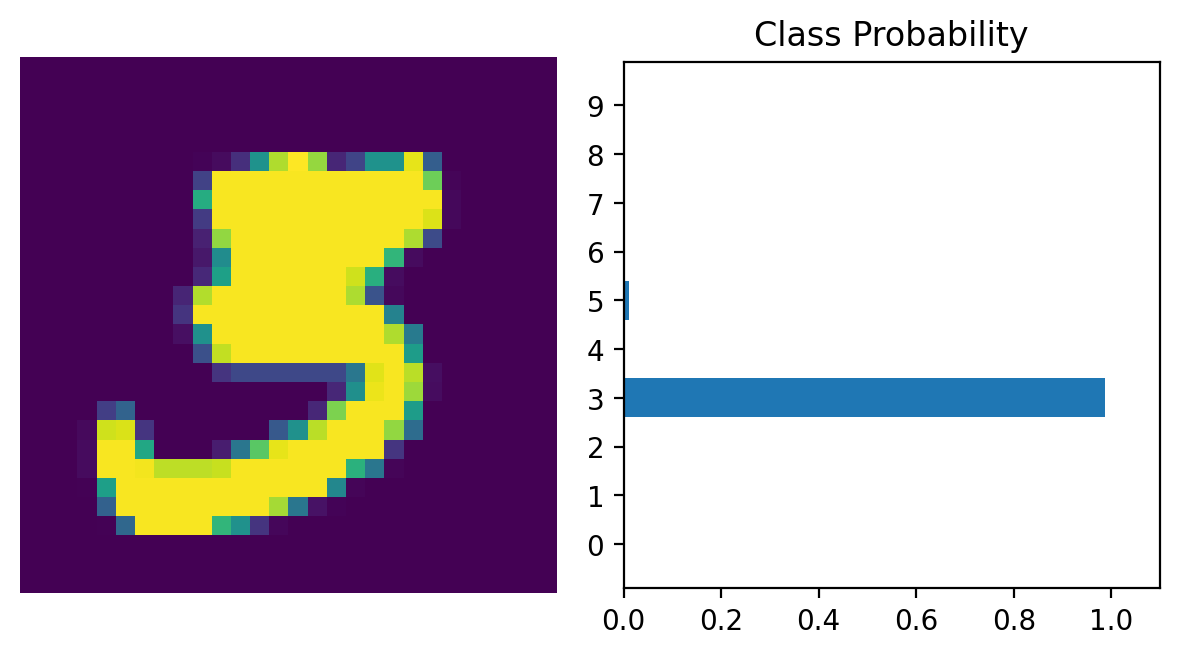

In [20]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
helper.view_classify(img.view(1, 28, 28), ps)

## Gráfica de perdida:

In [17]:
import matplotlib.pyplot as plt

def graficate(losses, generations):
    x = list(range(1, generations + 1))
    plt.scatter(x, losses, color = "blue", label = "losses")
    plt.plot(x, losses, color = 'blue')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.show()

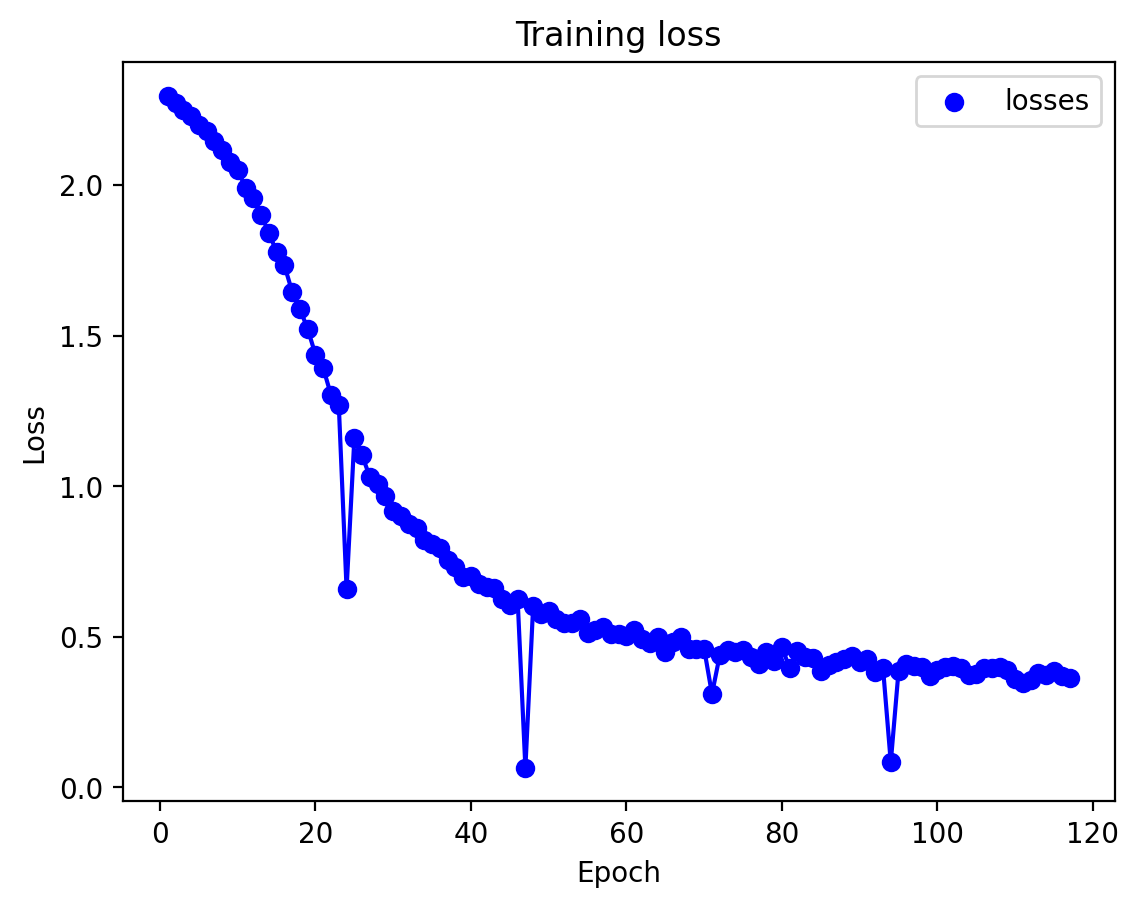

In [18]:
graficate(losses, len(losses))

En la gráfica anterior podemos observar como disminuye el valor de perdida conforme avanzan las iteraciones en la red neuronal.

## Conclusión:

Sigue siendo impresionante el comportamiento de una red neuronal al aprender de los datos de entrada en cada iteración con ayuda del paso frontal y del mecanismo de retropropagación, para reducir cada vez más el error y mejorar así su precisión. Además, el uso de herramientas facilita bastante el manejo de operaciones matriciales, ya que cuenta con funciones para poner en marcha cualquier arquitectura de forma rápida, así como su entrenamiento.

En la práctica realizada se pudo aplicar esta librería y sus funciones ya hechas para entrenar una red que clasifique el número de una imagen de entrada, además de graficar el valor de pérdida que genera la red con cada iteración, validando su funcionamiento.

Finalmente, usando estas herramientas se ahorrará más tiempo y esfuerzo en entrenar arquitecturas de redes neuronales más complejas para resolver problemas aún más complejos.



## Referencias

[1] Udacity Computer Vision Nanodegree

[2] Pytorch https://pytorch.org/